# Causal analysis with PyMC: Answering "What If?" with the new `do` operator

## Why Causal Analysis?

Causal analysis is rapidly gaining popularity, but why?

Without a causal understanding of the world, it's often impossible to take actions that lead to a certain outcome. For example, you would not put a lighter under the thermometer to make the outside temperature go up. The obvious reason is that you know that the temperature affects the thermometer, but not the other way around.

In business, we are constantly taking actions to achieve a certain outcome (e.g. increase sales). So in order not to waste our time heating our proverbial thermometer, we need a solid understanding of the *causal relationships* of our business processes.

Machine learning methods might help us *predict* what's going to happen with great accuracy, but what's the value of that if we don't know how to affect the outcome.

## Why Bayesian Causal Analysis?

Causal analysis is usually embedded in a Frequentist framework, which comes with some well-documented baggage (see e.g. [Scientists rise up against statistical significance](https://www.nature.com/articles/d41586-019-00857-9)).

It is sometimes claimed that Bayesian statistics does not allow for causal analysis. However, as we will demonstrate in this blog post, this is wrong. Combining these two fields provides many benefits over traditional causal analysis.

## Why Bayesian Causal Analysis *in PyMC*?
PyMC is a mature and highly-scalable package for Bayesian modeling with an approachable syntax. Rather than invent new frameworks for performing causal analysis, we can super-charge PyMC for Bayesian Causal Analysis with some minor new features (i.e. the new do operator).

In sum, there are several advantage compared to more traditional Frequentist causal inference approaches:

* Frequentist statistics has well-known pratical issues that make it prone to misuse (p-hacking etc).
* PyMC is a well-established tool that allows building and inference of highly sophisticated models.
* If you already have a PyMC model, now you can do scenario anaysis and ask "What If" questions natively.

## Setting up

**NOTE:** The functionality we talk about in this post, relies on some experimental code. Therefore these functions exist in the suitably named [`pymc-experimental`](https://github.com/pymc-devs/pymc-experimental) repo. This new functionality will migrate into the main PyMC repo and be available to all users in the near future.

Setup an environment as follows:

```bash
mamba create -n do_blog_post python=3.11 pymc matplotlib numpy pandas seaborn scipy jupyterlab ipykernel python-graphviz
mamba activate do_blog_post
python -m ipykernel install --user --name do_blog_post
pip install pymc-experimental
pip install daft
```

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import pymc_experimental as pmx
import seaborn as sns
from packaging import version

In [2]:
# check we have the required versions
assert version.parse(pm.__version__) >= version.parse("5.5.0")
assert version.parse(pt.__version__) >= version.parse("2.12.3")
assert version.parse(pmx.__version__) >= version.parse("0.0.7")

In [3]:
# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 1234
sns.set_theme(context='notebook', style='white')

## Bayesian Causal Inference - simulating interventions with the new `do` operator.

### Example: Estimating impact of Google Ads with TV as a confounder

Let's say we are interested in measuring the effectiveness of our paid Google search ads on sales of our company. Pretty simple, right? We just correlate how much we're spending on search ads with our sales volume. If we wanted to get fancy, we could use a Bayesian Marketing-Mix Model or train a machine-learning model for this.

There is just one complication: the marketing team has recently launched a TV ad campaign. What do we expect the effects of that to be? Well, it hopefully increases sales. But it will most likely also increase the search volume for our product, which will in turn increase how much we're spending on Google ads. So it's totally possible that while Google ads and sales are strongly correlated, there is *no causal effect between the two*.

In causal inference terms, we're dealing with a **confounder** -- TV influences both: sales *and* Google ad spend. 

This example illustrates well why we really care about making *causal* claims about our data. Who cares if Google ad spend is *correlated* with sales, what we really want to know is whether we can increase sales by spending more on Google ads.

*Simplifying assumption*: In order to make our example a bit simpler, we will treat Google ads as either on or off. The idea would be that if we observe little search volume, we save costs by not running any ads, but if search volume is high, we are turning Google ads on. In reality, spending will probably be continuous, and while that's totally possible to model, things work out a bit neater if we treat it as binary for now.

### Formalizing the underlying Bayesian Causal Network

We can represent the above example with an idiomatic causal directed acyclic graph (DAG) where we have a binary treatment variable $Z$ (Google ads on/off) which may or may not causally influence an outcome $Y$ (sales). However, this relationship suffers from confounding by $C$ (TV) which causally influences both treatment and outcome. Further, we turn this into a Bayesian causal DAG by specifying probabilistic causal relationships between the nodes. A prior is placed on $C$ as it has no parent nodes.

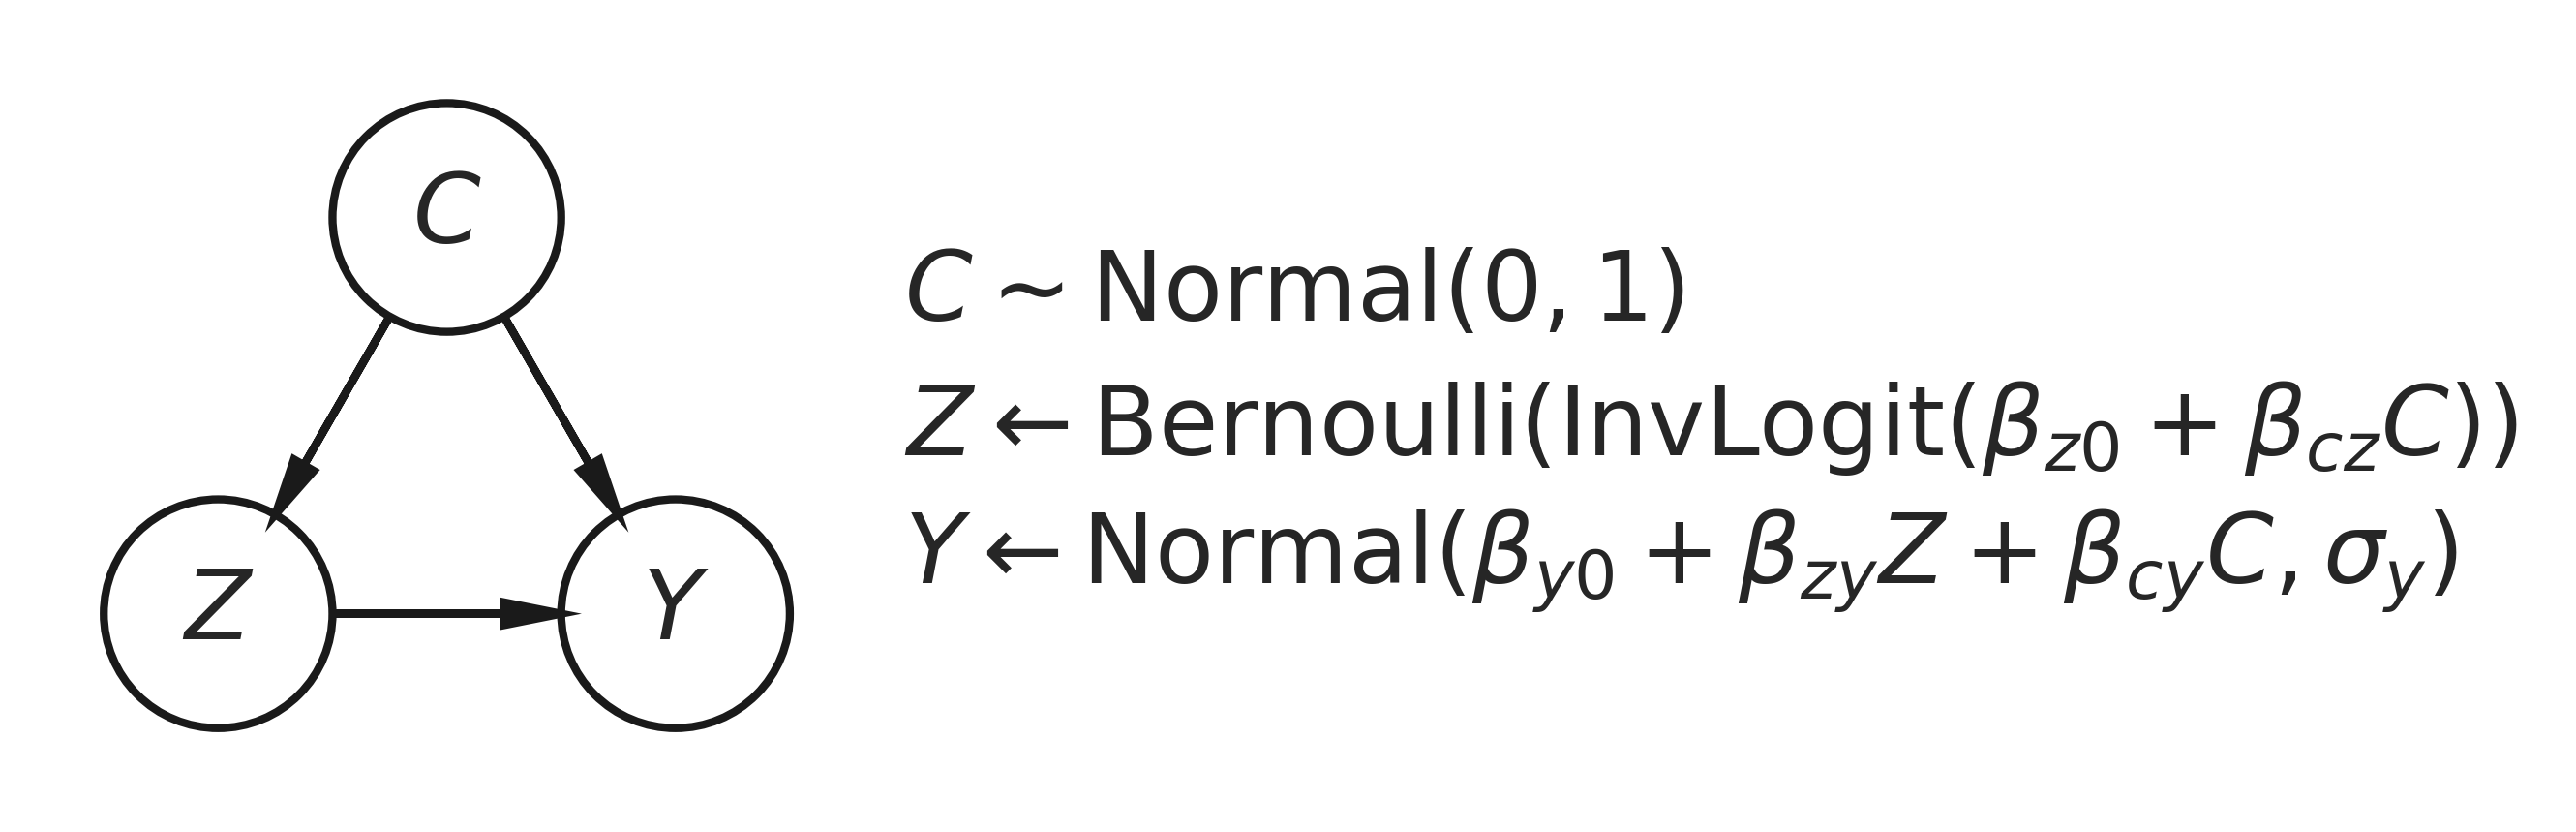

In [5]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(
    0.5,
    0.3,
    r"$Z \leftarrow \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$",
)
pgm.add_text(
    0.5,
    0,
    r"$Y \leftarrow \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$",
)
pgm.render(dpi=300);

Because our main relationship of interest here is between the treatment $Z$ and the outcome $Y$, we can see that this example corresponds to the idiomatic _confounded relationship_.

Our goal in this example is to establish the strength of the $Z \rightarrow Y$ causal relationship $\beta_{ZY}$. Assuming this is an accurate and complete causal story of our data (a big assumption!) then if we find that $\beta_{ZY}=0$ we'd conclude that there is no causal association. But if we can determine (using Bayesian methods) that $\beta_{ZY} \neq 0$ then we could conclude that there is a causal relationship, $Z \rightarrow Y$. 

Before we dive in to the code, let's specify some notation to make life a bit simpler:
* We have random variables $C$, $Z$, and $Y$
* These are different from observations, specific values, $c$, $z$, and $y$
* We have a set of latent parameters, $\theta = \{ \beta_{z0}, \beta_{y0}, \beta_{zy}, \beta_{zy}, \beta_{cz}, \sigma_{y} \}$

### Define the full data generating process in a PyMC model, $P(c, z, y, \theta)$

This next step may seem slightly alien to many existing PyMC users. We are going to define an 'empty' model, not conditioned on any data at all. This can be thought of as a 'pure' description of our data generating process, totally divorced from any actual data.

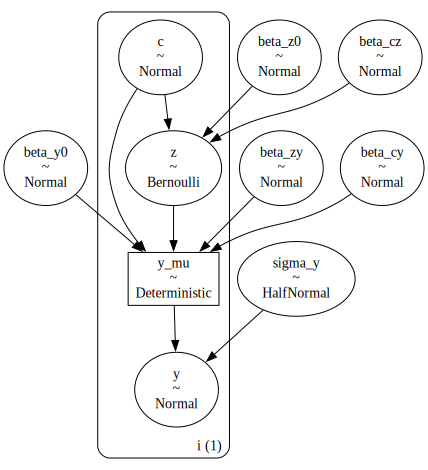

In [6]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on y <- c -> z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on z -> y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")


pm.model_to_graphviz(model_generative)

### Simulating data

Having defined the full joint distribution, we are first going to use it to generate simulated data with known effect sizes, to then test if we can recover them. 

In order to do that, we are going to specify some true parameter values that govern the causal relationships between nodes. Importantly, we will set the true causal influence of $Z$ upon $Y$ to be equal to 0, that is $\beta_{zy}=0$. This is known the true [Average Treatment Effect (ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect). If you recall our real-world example, this would correspond to Google ads having no causal effect on sales.

Of course, in real-world situations we will not know what the true ATE is. We only know it here because we are simulating the data and know the ground truth. Our goal is to estimate what the ATE is, and testing how well we can infer known parameters from the data alone (an excercise called Parameter Recovery) is a very useful excercise. If we can't recover the parameters in a simple toy simulated world, then we shouldn't have much faith that we can estimate the true effects in more complex real-world dataset.

While there are other ways to do this, here we will use the new `do` operator to generate a new model with the paramters set to certain values.

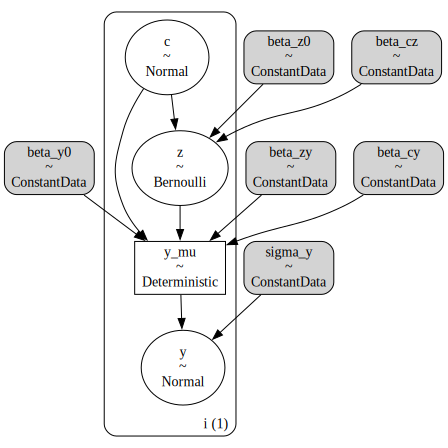

In [7]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

model_simulate = do(model_generative, true_values)

pm.model_to_graphviz(model_simulate)

Let's unpack this a little bit. The `do`-function takes a `pymc.Model` object and a dict of parameter values. It then returns a *new* model where the original random variables (RVs) have been converted to constant nodes taking on the specified values. 

But we're just warming up here, a bit further below, we'll see a much cooler application of the `do`-operator.

Next, we'll sample from this new model to obtain samples from distibution $P(C, Z, Y | \theta)$. Note that we'll use `pm.sample_prior_predictive` (not `pm.sample` because we are not doing any inference).

Sampling: [c, y, z]


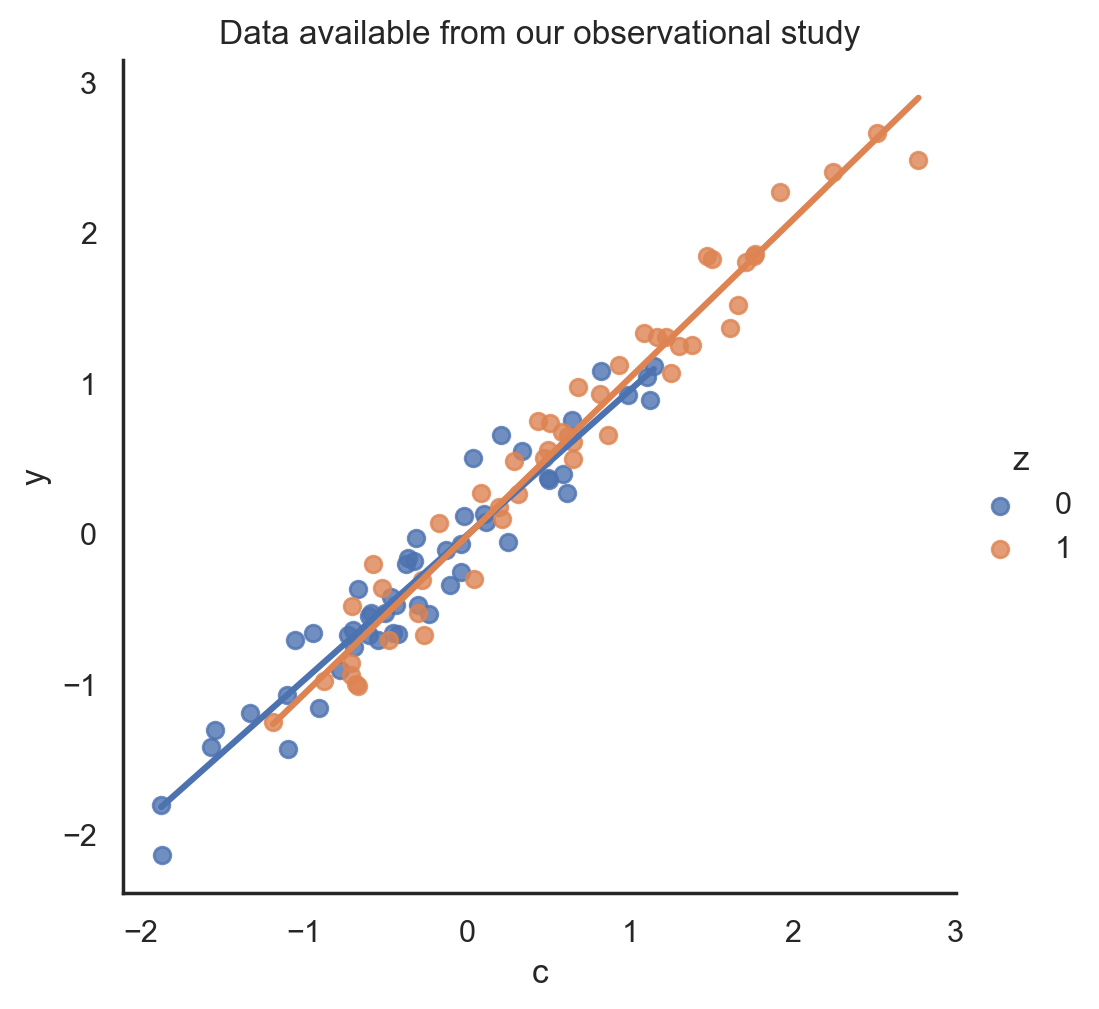

In [8]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

df = pd.DataFrame(observed).sort_values("c", ascending=False)
ax = sns.lmplot(df[["c", "z", "y"]], x="c", y="y", hue="z", ci=None)
ax.set(title="Data available from our observational study");

This plot shows TV spend (c) vs sales (y), grouped by whether Google ads (z) have been turned off (0) or on (1).

is shifted right to those who did not receive the discount yet, $Z=0$, meaning that indeed, those that have been customers longer, were more likely to have gotten the discount. 

Critically, we also see an _upwards_ shift of the outcome $Y$ when we take the treatment.

We can also see that customers who have been with us longer (c) tend to purchase more (y).  

_Note: lines through the data are carried out automatically by `seaborn`'s `lmplot` function, they are not the result of any Bayesian estimation._

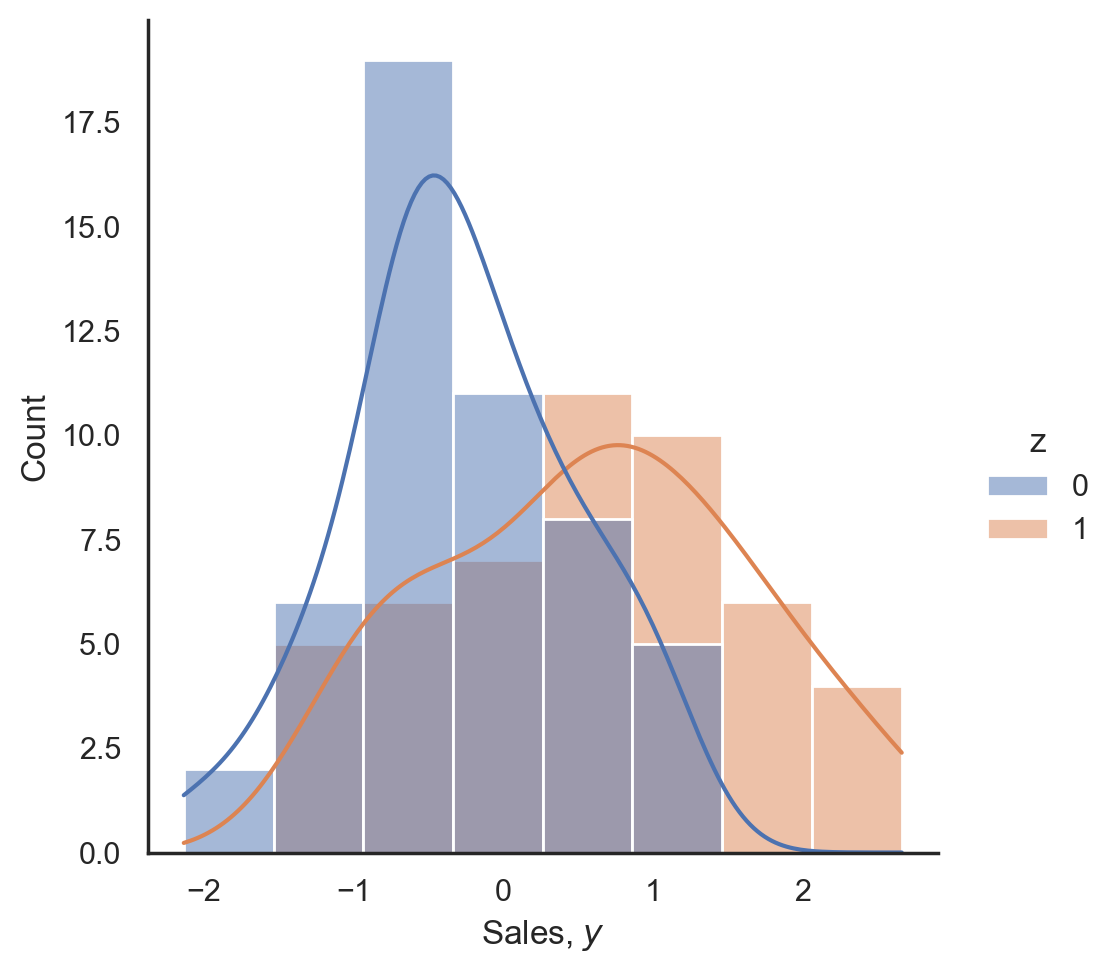

In [9]:
# NEW PLOT BY BEN
# If we just did the basic analysis of what our sales (y) look like based on 
# google ads being turned on (z=1) or off (z=0), then it looks like there's a big difference
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

# That looks like google adwords had a massice effect of our sales. The distribution of sales
# looks to be shifted up (to the right) by quite a lot.

# Optionally do a Bayesian t-test model (y ~ z) and show a credibly non zero effect of z (google ad words). 
# So being Bayesian is not enough to get around this problem!

### Inferring model parameters, $P( \theta | c, z, y)$

Let's next turn to inference. For that, we could just redefine the above model and use the `observed` kwarg as is common in PyMC.

However, we can do something a bit cooler than that and use another new function called `observe`. This function takes a model and data, and returns a new model with the data set as `observed` on our target RV. 

Importantly, we want to derive this observed model from our original "empty" `model_generative` from above, so that no parameters are fixed in place.

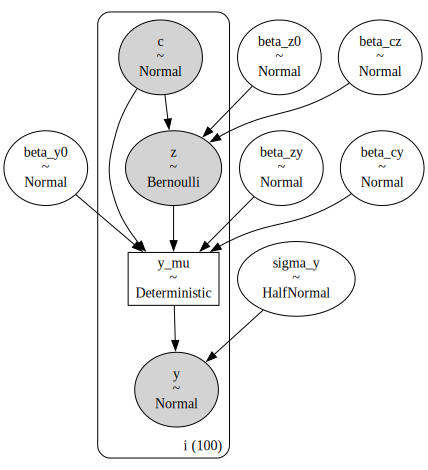

In [10]:
model_inference = observe(model_generative, 
                          {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))
pm.model_to_graphviz(model_inference)

Now we can press the Inference Button(TM) and sample from our posterior as if we had defined our model in the classic way.

In [11]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can inspect our posterior distributions using `arviz`. By plotting the known parameter values we used to generate the simulated data, we can confirm that the inference step has done a good job of estimating these values.

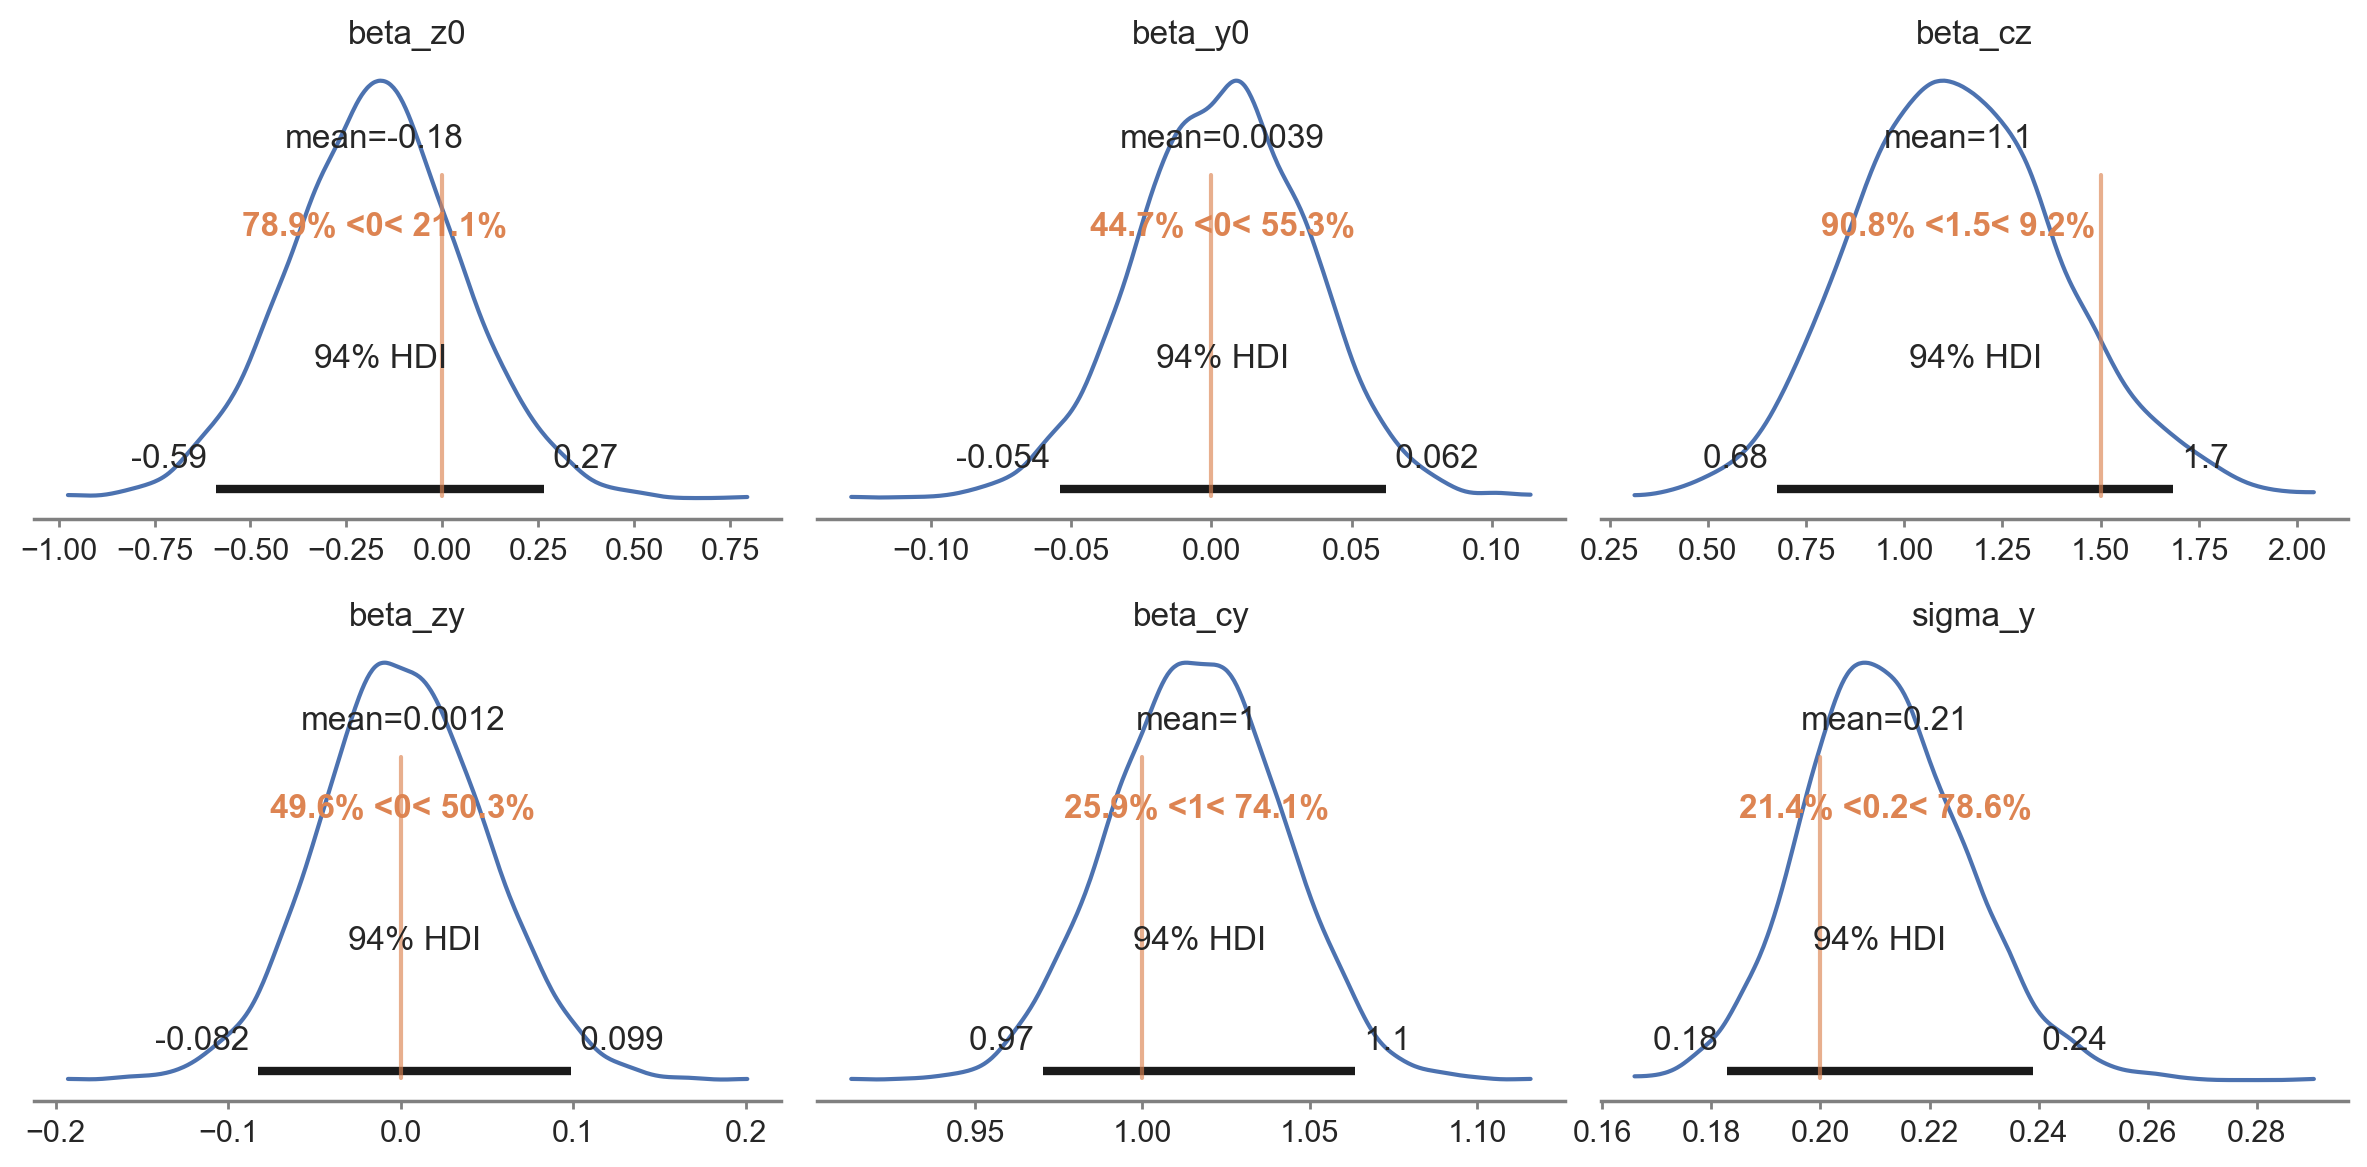

In [12]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

So far we've simply demonstrated that the generative model we wrote can do a good job of recovering the parameters based on data which was generated directly from that data generating process. This can be a very valuable excercise and represents a new Bayesian workflow for those interested in parameter recovery studies. But let's not get distracted by this and return to our causal focus.

### 🔥 Counterfactuals 🔥

Now we are ready for the coolest use case for the `do` operator -- doing counterfactual reasoning! This is where we're asking **"What if?"**: What if we stopped Google ads? What if we increased spending on Google ads? What would we expect our data to look like in these scenarios?

Once we have these two hypotheticals, we estimate the thing we're really interested in: **How strong is the causal influence of Google ads on sales, independent of the TV confounder?**

For those familiar with causal inference, you'll know this as the *Average Treatment Effect*:

$$
ATE = P(Y | c, do(z=1)) -  P(Y | c, do(z=0))
$$

To achieve this in PyMC, we can use the `do` function to calculate the counterfactuals as explained above. However, before diving in with something like the following:

```python
model_z0 = do(model_inference, {"z": np.zeros(N, dtype="int32")})
```

we have to explicitly inject the observed values of $C$ into the model. This step may not be necessary in future versions of PyMC.

In [13]:
# This step is required at the moment, but may not be necessary in future versions of PyMC
model_counterfactual = do(model_inference, {"c": df["c"]})

Now we are able to use the `do` operator to set all the values of $Z$ to either 0 or 1 to calculate $P(Y | c, do(z=0))$ and $P(Y | c, do(z=1))$, respectively. Using `pm.sample_posterior_predictive()` we generate the data we would expect to see under these two causal interventions.

In [14]:
# Generate model with Z=0
model_z0 = do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)

with model_z0:
    # Sample from P(Y | c, do(z=0))
    idata_z0 = pm.sample_posterior_predictive(
        idata, predictions=True, var_names=["y_mu"], random_seed=SEED
    )


# Generate model with Z=1
model_z1 = do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

with model_z1:
    # Sample from P(Y | c, do(z=1))
    idata_z1 = pm.sample_posterior_predictive(
        idata, predictions=True, var_names=["y_mu"], random_seed=SEED
    )

# calculate estimated ITE
ATE_est = idata_z1.predictions - idata_z0.predictions

Sampling: []


Sampling: []


Let's take a peek at the modified `model_z0` which represents $P(Y | c, do(z=0))$. The graph structure will be the same for `model_z1`, the only thing that's different is the $z$ values, so we omit showing that visually.

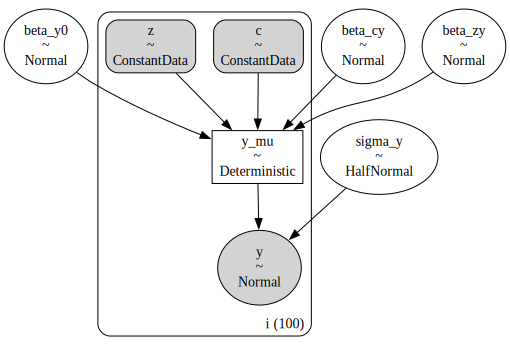

In [15]:
pm.model_to_graphviz(model_z0)

In [16]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    plt.tight_layout()


def print_percent_error(ATE_est, true_ATE):
    """Utility function to calculate and print the percent error."""
    percent_error = np.abs(ATE_est["y_mu"] - true_ATE) / true_ATE * 100
    hdi = az.hdi(percent_error).sel(i=0)["y_mu"].values
    return f"{percent_error.mean().data:.1f}% ({hdi[0]:.1f} - {hdi[1]:.1f})"

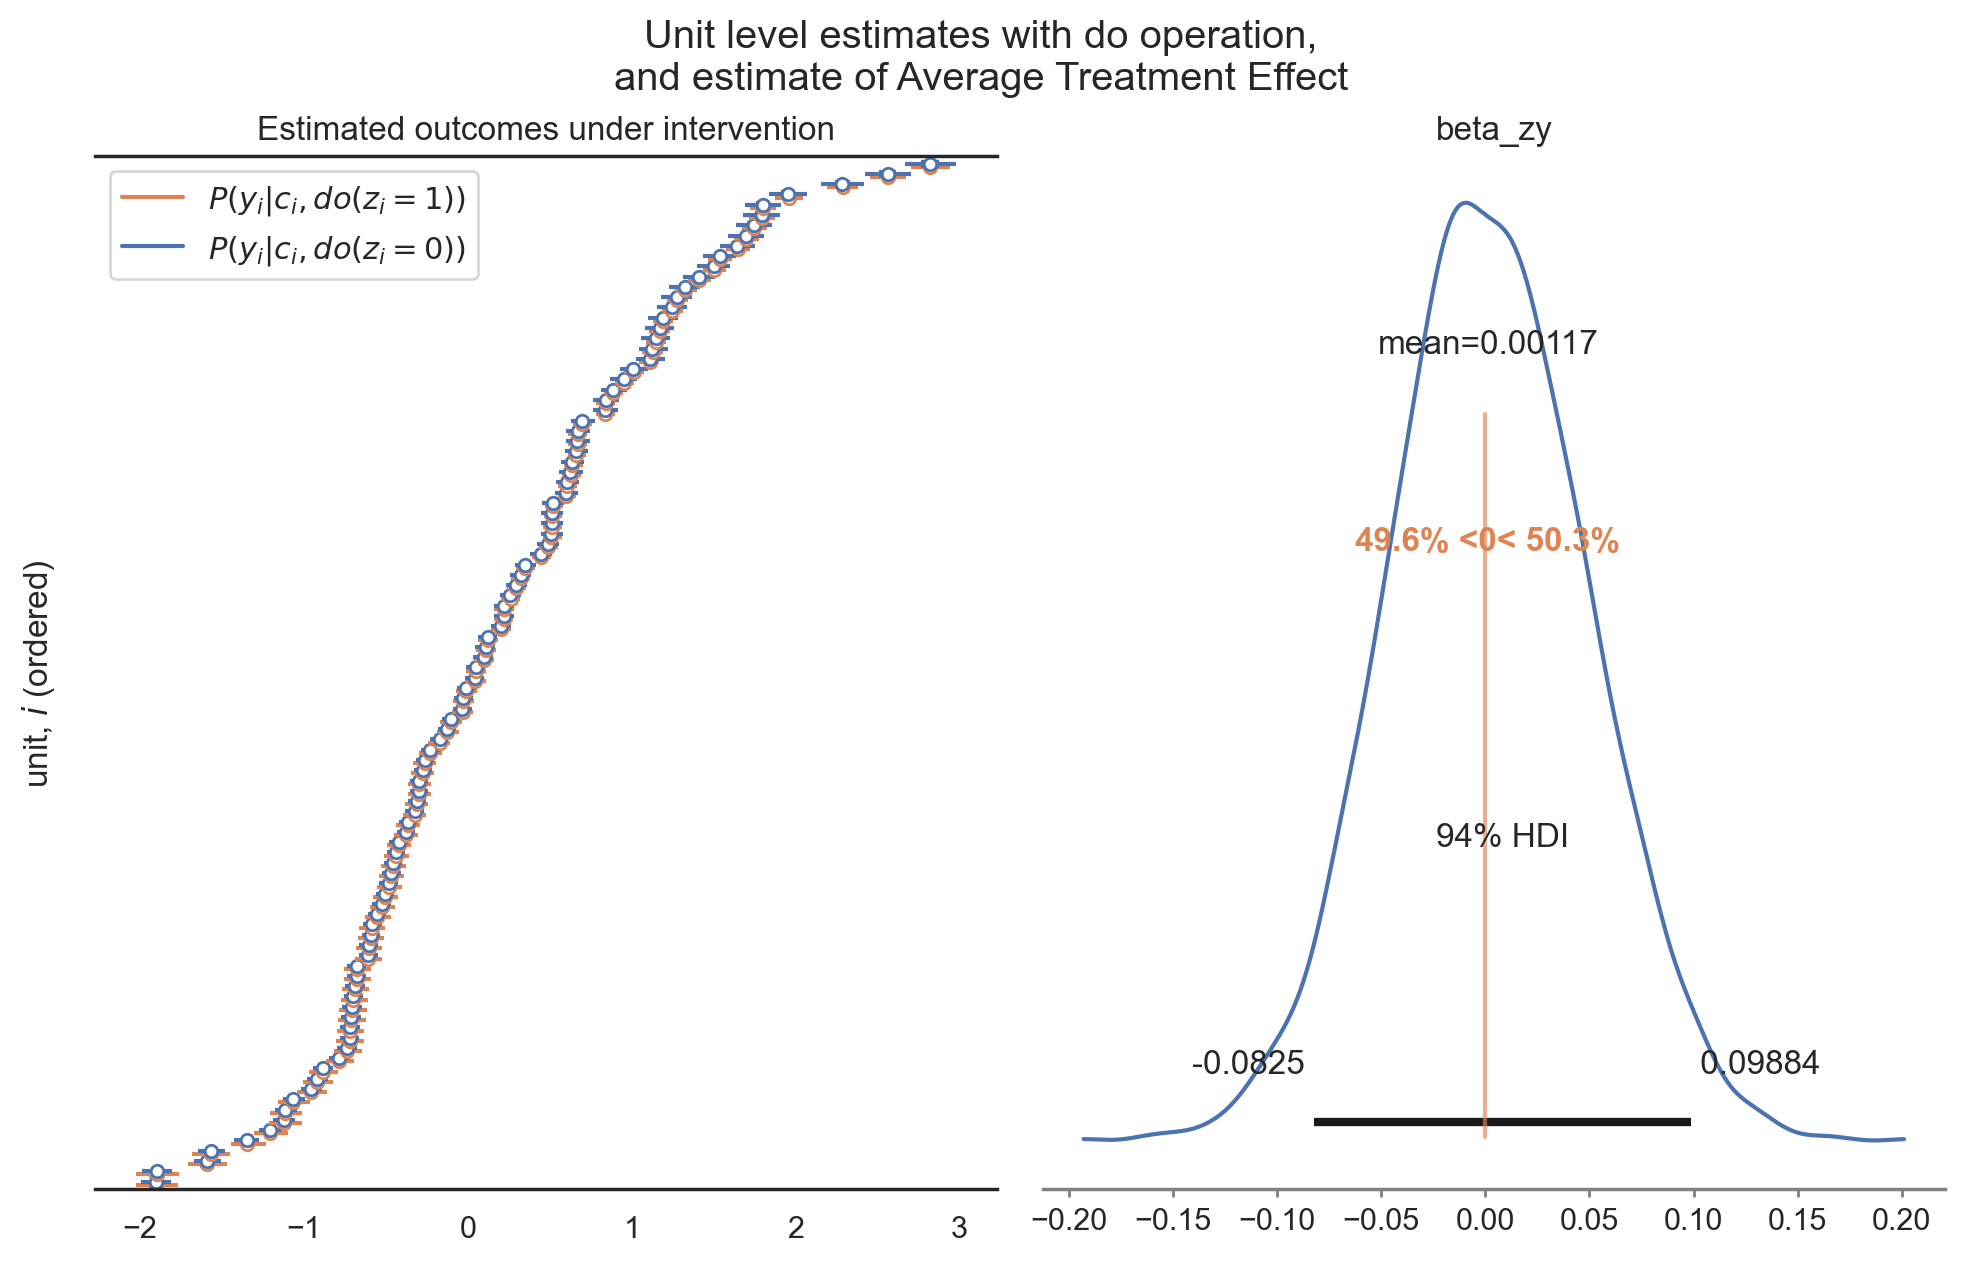

In [17]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)
plt.suptitle(
    "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
    y=1.05,
);

Results of our Bayesian causal inference. The left panel shows our individual level estimates of the outcome $y$ under the counterfactual situations of being in the control ($\operatorname{do}(z=0)$) or treatment ($\operatorname{do}(z=1)$) groups. Each individual has a different outcome due to the influence of the confounding variable, $C$. The right panel shows our posterior estimate of the Average Treatment Effect of $Z \rightarrow Y$. We can see that we have correctly recovered the true value (of 1) from our simulated data, and that we have quite a tight 95% Bayesian credible interval which indicates relatively high confidence in this estimate. 

As a reminder to any non-Bayesians reading, the model assumes that there is _one_ single (but unknown) treatment effect that is constant across all individuals. The posterior distribution represents the relative credibility of a range of different magnitudes of causal impacts, as such relies upon the [subjective interpretation of probability](https://en.wikipedia.org/wiki/Probability_interpretations).

This example has demonstrated that we can use Bayesian inference methods to estimate the causal effects, and that the `do` operator is enormously helpful in doing this.

## High-level overview of derived models
Just in case that was a bit confusing, here's a high level summary of what we've done in terms of graph manipulation. In most situations, users with data actually start with defining their own `model_inference`. That is, they normally build a model of the data generating process, conditioned on the data, ready to generate posterior draws with `pm.sample`. They would then just use `do` in the way we've shown to calculate causal quantities. Here, we went the long way around simply to emphasise the different graph manipulations we can do. Users would pretty much only want to start with an empty `model_generative` and create a `model_simulate` if they were conducting parameter recovery.

![](schematic.png)

## Technical details

If you'd like to know more of how the `do` operator *actually* works, read on, otherwise, feel free to skip to the summary.

### How does the `do` operator work under the hood?

The `do` operator performs two simple steps:
1. It takes a given node in a graph and sets that node at the desired value.
2. It removes any causal influence of this node by other nodes. It does this by removing all incoming edges into that node.

Here is a visual demonstration of that using an example from Pearl's book, [Causality](https://en.wikipedia.org/wiki/Causality_(book)).

![](sprinkler.png)

On the left of the figure we have a causal directed acyclic graph describing the causal relationships between season, whether a sprinkler has been on, whether it has rained, if the grass is wet, and if the grass is slippery. The joint distribution could be described as: 

$$
P(x_1, x_2, x_3, x_4, x_5) = P(x_1) P(x_3|x_1) P(x_2|x_1) P(x_4|x_3, x_2) P(x_5|x_4)
$$

On the right of the figure we have applied the `do` operator to examine what will happen if we set the sprinkler to be on. You can see that we have now set the value of that node, $x_3=1$ and we have removed the incoming edge (influence) of season, meaning that once we turn on the sprinkler manually, it's not influenced by the season anymore.

We could now describe this _interventional distribution_ as:

$$
P(x_1, x_2, \operatorname{do}(x_3=1), x_4, x_5) = P(x_1) P(x_2|x_1) P(x_4|x_3=1, x_2) P(x_5|x_4)
$$

As we've seen above, using the `do` operator to obtain the interventional distribution is a key part of causal inference. 

The most important take-home message is that we can ask what-if questions by taking a causal DAG, applying the `do` operator gives us back a new and different model. This latter point is key - when we intervene we are changing the causal influences in the system, the results of which cannot be predicted from a purely statistical approach.

Interested readers should check out the richly diagrammed and well-explained blog post [Causal Effects via the Do-operator](https://towardsdatascience.com/causal-effects-via-the-do-operator-5415aefc834a) by [Shawhin Talebi](https://shawhin.medium.com) as a good place to start.

## Summary

If we want to make better decisions, we need a solid understanding of how our actions affect outcomes. This is the domain of causal analysis.

If we don't want to be fooled by the randomness in our data, we need to know how uncertain we are in our estimates. This is the domain of Bayesian statistics.

Combining these two gives us a very powerful framework for doing data science that provides actual business value. As we leave the domain of pure associations or predictions, we stop merely providing insight into what has happened or will happen, but also what to *do* to maximize chances of a favorable outcome.

With the new functionality presented here, PyMC emerges as a powerful tool to aid in this endeavour. 

## Further reading
* Glymour, M., Pearl, J., & Jewell, N. P. (2016). [Causal inference in statistics: A primer](https://www.wiley.com/en-us/Causal+Inference+in+Statistics%3A+A+Primer-p-9781119186847). John Wiley & Sons.
* Pearl, J. & Mackenzie, D. (2018). [The book of why: the new science of cause and effect](https://en.wikipedia.org/wiki/The_Book_of_Why). Basic books.
* Pearl, J. (2009). [Causality](https://en.wikipedia.org/wiki/Causality_(book)). Cambridge University Press
* Talebi, S. (2022) [Causal Effects via the Do-operator](https://towardsdatascience.com/causal-effects-via-the-do-operator-5415aefc834a).
* [Causal inference in statistics: A primer](https://www.wiley.com/en-us/Causal+Inference+in+Statistics%3A+A+Primer-p-9781119186847).
* Blog post on [Out of model predictions with PyMC](https://www.pymc-labs.io/blog-posts/out-of-model-predictions-with-pymc/)
* For the related approach of quasi-experimentation, check out [`CausalPy`](https://causalpy.readthedocs.io/en/latest/), a package we put together for causal inference in situations, built on top of PyMC (also see our [video from PyData Global 2022](https://youtu.be/gV6wzTk3o1U) about this topic).